<a href="https://colab.research.google.com/github/msolorzan/TensorFlow-projects/blob/main/DucksVsHens_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ducks Vs Hens

In [1]:
import os

for dirpath, dirnames, filenames in os.walk('/content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas
There are 2 directories and 0 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/train
There are 0 directories and 397 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/train/gallina
There are 0 directories and 381 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/train/pato
There are 2 directories and 0 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/test
There are 0 directories and 163 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/test/pato
There are 0 directories and 170 images in /content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/test/gallina


## Preprocessing images

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_BATCH = 32
IMG_SHAPE = (240, 240)

train_dir = '/content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/train'
test_dir = '/content/drive/MyDrive/Data_science/TensorFlow/patos_gallinas/test'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print(f'Training images: ')
train_data = train_datagen.flow_from_directory(train_dir, class_mode = 'binary', target_size = IMG_SHAPE)

print(f'Testing images: ')
test_data = test_datagen.flow_from_directory(test_dir, class_mode = 'binary', target_size = IMG_SHAPE)

Training images: 
Found 778 images belonging to 2 classes.
Testing images: 
Found 333 images belonging to 2 classes.


In [3]:
# Create a tensorboard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + datetime.datetime.now().strftime('%Y/%m/%d - %H:%M:%S')
  tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir)
  print(f'Saving TensorBoard log files to: ')
  return tensorboard_callbacks

In [4]:
efficientnet_v2_imagenet1k_b1_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2'

In [5]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
import tensorflow_hub as hub

In [6]:
def create_model(model_url,img_shape, num_clases = 2):
  '''
  Takes a url from tensorflow hub which was pretrained

  Args:
  model_url = url from tensorflow hub that contains a prentrained model architecture
  img_shape = Shape of the images
  num_classes = By default 2 (binary), but it can be another int number for a categorical model

  Returns:
  An uncompiled tensorflow model as feature extractor
  '''

  # Usign the pretained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = img_shape + (3,))
  # Create the sequential model
  model = Sequential([
      feature_extractor_layer,
      Dense(1,
            activation = 'sigmoid',
            name = 'output_layer') # Because of are only 2 outputs
  ])

  return model

# Create the efficientnet_v2_b1

In [7]:
efficientnet_v2_b1 = create_model(efficientnet_v2_imagenet1k_b1_url, IMG_SHAPE, train_data.num_classes)
efficientnet_v2_b1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             6931124   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 6,932,405
Trainable params: 1,281
Non-trainable params: 6,931,124
_________________________________________________________________


## Compile the efficientnet_v2_b1

In [8]:
efficientnet_v2_b1.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

## Fit the momdel

In [9]:
effnet_v2_b1_history = efficientnet_v2_b1.fit(x = train_data,
                                              batch_size = IMG_BATCH,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks =[create_tensorboard_callback(dir_name = 'tensorflow_hub', experiment_name = 'efficientnet_v2_b1')]
                                              )

Saving TensorBoard log files to: 
Epoch 1/5
 6/25 [======>.......................] - ETA: 1:06 - loss: 0.6742 - accuracy: 0.6094

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/25 [==============================] - 208s 8s/step - loss: 0.4394 - accuracy: 0.8728 - val_loss: 0.3261 - val_accuracy: 0.8829
Epoch 2/5
25/25 [==============================] - 22s 906ms/step - loss: 0.1617 - accuracy: 0.9820 - val_loss: 0.2497 - val_accuracy: 0.8829
Epoch 3/5
25/25 [==============================] - 22s 895ms/step - loss: 0.1002 - accuracy: 0.9897 - val_loss: 0.2365 - val_accuracy: 0.8829
Epoch 4/5
25/25 [==============================] - 22s 911ms/step - loss: 0.0755 - accuracy: 0.9897 - val_loss: 0.2315 - val_accuracy: 0.8769
Epoch 5/5
25/25 [==============================] - 22s 877ms/step - loss: 0.0620 - accuracy: 0.9910 - val_loss: 0.2293 - val_accuracy: 0.8739


In [10]:
import pandas as pd
loss = pd.Series(effnet_v2_b1_history.history['loss'])
val_loss = pd.Series(effnet_v2_b1_history.history['val_loss'])
val_accuracy = pd.Series(effnet_v2_b1_history.history['val_accuracy'])
accuracy = pd.Series(effnet_v2_b1_history.history['accuracy'])

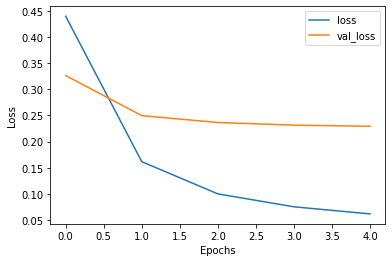

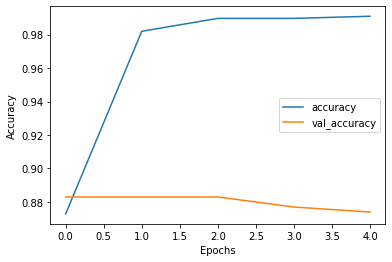

In [11]:
import matplotlib.pyplot as plt
import numpy as np
epochs = np.arange(5)

plt.plot(epochs, loss,  label = 'loss')
plt.plot(epochs, val_loss, label = 'val_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, label = 'accuracy')
plt.plot(epochs, val_accuracy, label = 'val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
from google.colab import files

files.upload()

Saving gallina.jpeg to gallina.jpeg


{'gallina.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x06\x06\x06\x06\x07\x06\x07\x08\x08\x07\n\x0b\n\x0b\n\x0f\x0e\x0c\x0c\x0e\x0f\x16\x10\x11\x10\x11\x10\x16"\x15\x19\x15\x15\x19\x15"\x1e$\x1e\x1c\x1e$\x1e6*&&*6>424>LDDL_Z_||\xa7\x01\x06\x06\x06\x06\x07\x06\x07\x08\x08\x07\n\x0b\n\x0b\n\x0f\x0e\x0c\x0c\x0e\x0f\x16\x10\x11\x10\x11\x10\x16"\x15\x19\x15\x15\x19\x15"\x1e$\x1e\x1c\x1e$\x1e6*&&*6>424>LDDL_Z_||\xa7\xff\xc2\x00\x11\x08\x04P\x02\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x001\x00\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x06\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x02\xf4\xb4\xce\x90\xea\x102\xe9\xca\xca\xbc\xbd\xc0\x0eP\x8d\xc3\xa2\xb4\xce\xd5TI\x8e&\xd9\xd7!P\xbc\xc8\xf2\xa9\x97+X\x91]]fwtF\x9a\xce\x99P\x94\xd3\x1d6Z\xf9\xdd,\x93\x01NU\x0b\xcb\x05I\r\x92\xba\xcfN\xc9d

In [13]:
files.upload()

Saving pato.jpeg to pato.jpeg


{'pato.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x06\x06\x06\x06\x07\x06\x07\x08\x08\x07\n\x0b\n\x0b\n\x0f\x0e\x0c\x0c\x0e\x0f\x16\x10\x11\x10\x11\x10\x16"\x15\x19\x15\x15\x19\x15"\x1e$\x1e\x1c\x1e$\x1e6*&&*6>424>LDDL_Z_||\xa7\x01\x06\x06\x06\x06\x07\x06\x07\x08\x08\x07\n\x0b\n\x0b\n\x0f\x0e\x0c\x0c\x0e\x0f\x16\x10\x11\x10\x11\x10\x16"\x15\x19\x15\x15\x19\x15"\x1e$\x1e\x1c\x1e$\x1e6*&&*6>424>LDDL_Z_||\xa7\xff\xc2\x00\x11\x08\x03\xd5\x02\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x000\x00\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x02\xe1+\x9e\x89\xb372]\xe7:^|;\xf0\x95e*hP\xb6Q@\xd29z8\xf5:\\\xda\xc7.\xbc\xd3\x8e:b\xb3\xe4\xf5\xf9\x8f=\xb9\xd6\xba\x15\xdb\x12\xa6$\xd6\xae3\xc7\xd7\xc6\xf3\xc5\xd5\xd3\x94\xeb$\xe6\xd4\'\xa3\x87\xae^\xfds\xb

In [15]:
def load_and_pred(file_name, img_shape):


  img = tf.io.read_file(file_name)

  img = tf.image.decode_image(img)

  img = tf.image.resize(img, size = (img_shape, img_shape))

  img = img/255.

  return img

In [16]:
hen = load_and_pred('/content/gallina.jpeg', 240)

In [19]:
efficientnet_v2_b1.predict(tf.expand_dims(hen, axis = 0))

1/1 [==============================] - 2s 2s/step


array([[0.01677751]], dtype=float32)

In [20]:
duck = load_and_pred('/content/pato.jpeg', 240)
efficientnet_v2_b1.predict(tf.expand_dims(duck, axis = 0))

1/1 [==============================] - 0s 45ms/step


array([[0.9733199]], dtype=float32)